# Type Curve Generation: Normalization and Probabilistic Profiling
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Production Data Analysis (RTA/DCA)

## Objective
Normalize production history from multiple wells to generate P10, P50, and P90 "Type Curves."

## 1. Import Libraries
We will use `pandas` for time-series manipulation and `numpy` for statistical aggregation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded.")

Libraries loaded.


## 2. Load Data
We are loading a dataset containing 15 wells. The columns are `WellID`, `Date`, and `OilRate`.

Total rows: 900
Unique Wells: 15


,WellID,Date,OilRate
0,Well_01,2020-04-01,423.251867
1,Well_01,2020-05-01,835.484473
2,Well_01,2020-06-01,856.070324
3,Well_01,2020-07-01,782.534323
4,Well_01,2020-08-01,776.189383


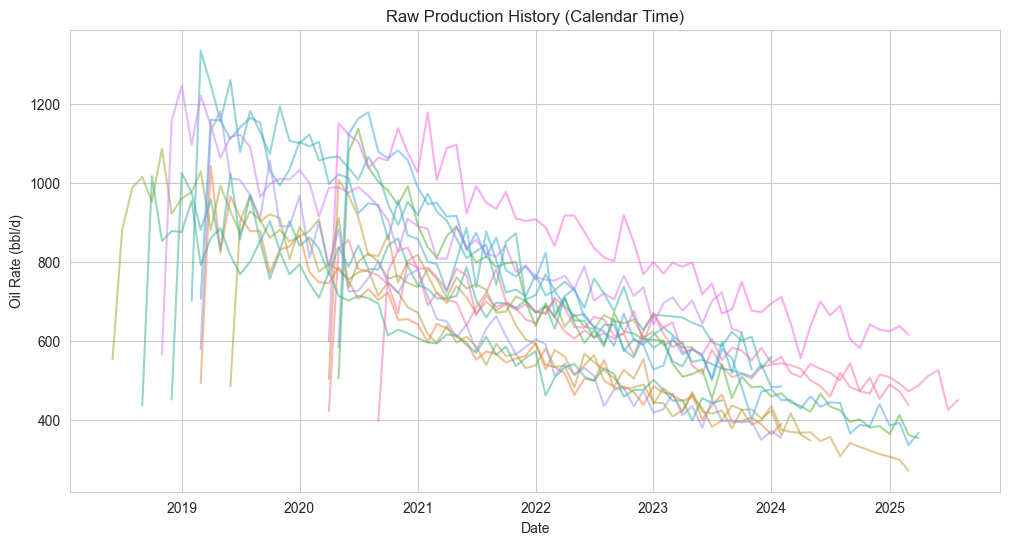

In [2]:
# Load dataset
df = pd.read_csv('production_data.csv', parse_dates=['Date'])

# Inspect the raw data
print(f"Total rows: {len(df)}")
print(f"Unique Wells: {df['WellID'].nunique()}")
display(df.head())

# Visualize Raw Data (Un-normalized)
plt.figure()
sns.lineplot(data=df, x='Date', y='OilRate', hue='WellID', legend=False, alpha=0.5)
plt.title("Raw Production History (Calendar Time)")
plt.ylabel("Oil Rate (bbl/d)")
plt.xlabel("Date")
plt.show()

## 3. Data Normalization (Peak Rate Alignment)

The raw plot above is difficult to interpret because wells started at different times. To create a Type Curve, we must align all wells to a common start point.

**Strategy:**
1. Identify the **Peak Rate** index for each well.
2. Shift the time axis so that the Peak Rate occurs at $t=0$.
3. Truncate data before the peak (ramp-up period) to focus on the decline phase.

,WellID,Date,OilRate,NormalizedMonth
2,Well_01,2020-06-01,856.070324,0
3,Well_01,2020-07-01,782.534323,1
4,Well_01,2020-08-01,776.189383,2
5,Well_01,2020-09-01,765.905463,3
6,Well_01,2020-10-01,743.835124,4


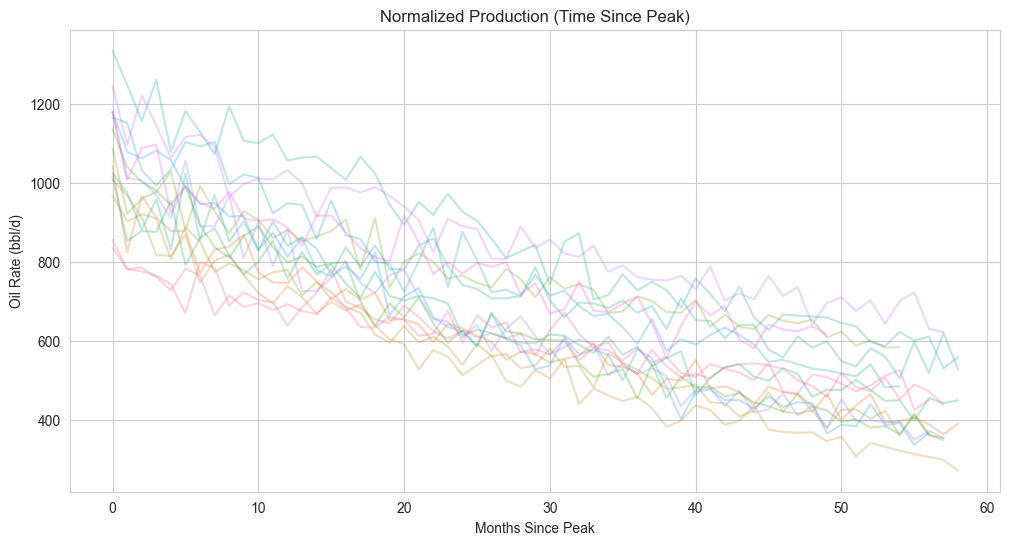

In [3]:
normalized_data = []

for well in df['WellID'].unique():
    well_df = df[df['WellID'] == well].sort_values('Date').reset_index(drop=True)
    
    # Find index of maximum rate
    peak_index = well_df['OilRate'].idxmax()
    
    # Slice data from peak onwards (ignoring ramp-up)
    decline_phase = well_df.iloc[peak_index:].copy()
    
    # Create Normalized Time (Months since Peak)
    decline_phase['NormalizedMonth'] = range(len(decline_phase))
    
    normalized_data.append(decline_phase)

# Concatenate back to single DataFrame
df_norm = pd.concat(normalized_data)

display(df_norm.head())

# Visualize Normalized Data
plt.figure()
sns.lineplot(data=df_norm, x='NormalizedMonth', y='OilRate', hue='WellID', legend=False, alpha=0.3)
plt.title("Normalized Production (Time Since Peak)")
plt.ylabel("Oil Rate (bbl/d)")
plt.xlabel("Months Since Peak")
plt.show()

## 4. Survivorship Bias Check
As time increases, fewer wells have data (older wells drop off or haven't reached that age). This is **Survivorship Bias**. We need to count the number of active wells per month to ensure our statistics are statistically significant.

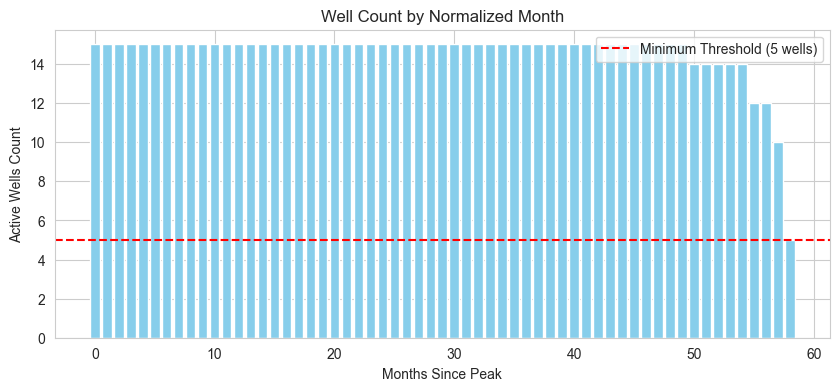

In [4]:
# Count active wells per normalized month
well_count = df_norm.groupby('NormalizedMonth')['WellID'].count()

plt.figure(figsize=(10, 4))
plt.bar(well_count.index, well_count.values, color='skyblue')
plt.axhline(y=5, color='r', linestyle='--', label='Minimum Threshold (5 wells)')
plt.title("Well Count by Normalized Month")
plt.xlabel("Months Since Peak")
plt.ylabel("Active Wells Count")
plt.legend()
plt.show()

# Filter data where well count < 5 (optional, to maintain statistical validity)
valid_months = well_count[well_count >= 5].index
df_norm_filtered = df_norm[df_norm['NormalizedMonth'].isin(valid_months)]

## 5. Statistical Aggregation (P10, P50, P90)

We calculate the percentiles at every normalized month.
* **P90**: 10th percentile of the data distribution (Low Case).
* **P50**: 50th percentile (Median Case).
* **P10**: 90th percentile (High Case).

*Note: In O&G, P90 usually refers to 90% probability of exceeding the value (conservative), so it corresponds to the lower numeric quantile.*

In [5]:
# Group by Normalized Month and calculate quantiles
type_curves = df_norm_filtered.groupby('NormalizedMonth')['OilRate'].quantile([0.1, 0.5, 0.9]).unstack()

# Rename columns for clarity
type_curves.columns = ['P90_Low', 'P50_Mid', 'P10_High']

display(type_curves.head())

,P90_Low,P50_Mid,P10_High
NormalizedMonth,,,
0,901.124824,1087.613656,1221.360400
1,799.066495,975.313816,1131.121712
2,823.209296,966.915125,1130.428878
3,786.747692,970.031255,1127.112146
4,769.229497,923.469440,1062.071442


## 6. Final Visualization

We overlay the calculated Type Curves on top of the individual well data (gray background) to visualize the spread.

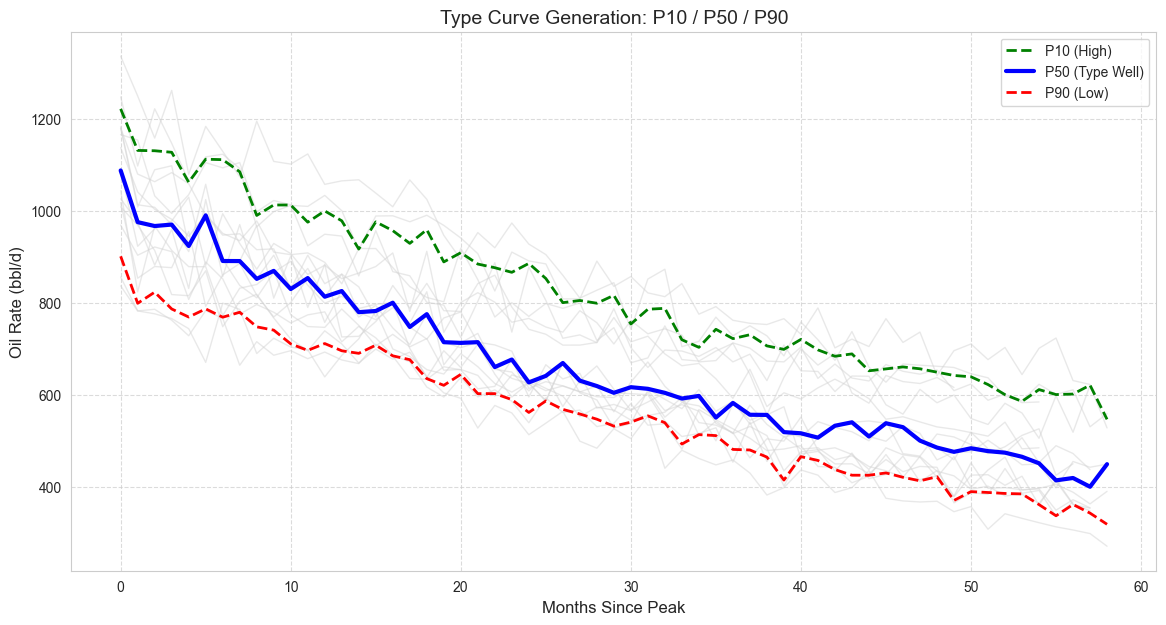

In [6]:
plt.figure(figsize=(14, 7))

# Plot individual wells (background)
for well in df_norm['WellID'].unique():
    subset = df_norm[df_norm['WellID'] == well]
    plt.plot(subset['NormalizedMonth'], subset['OilRate'], color='lightgray', linewidth=1, alpha=0.5)

# Plot Type Curves
plt.plot(type_curves.index, type_curves['P10_High'], color='green', linestyle='--', linewidth=2, label='P10 (High)')
plt.plot(type_curves.index, type_curves['P50_Mid'], color='blue', linewidth=3, label='P50 (Type Well)')
plt.plot(type_curves.index, type_curves['P90_Low'], color='red', linestyle='--', linewidth=2, label='P90 (Low)')

# Formatting
plt.title("Type Curve Generation: P10 / P50 / P90", fontsize=14)
plt.xlabel("Months Since Peak", fontsize=12)
plt.ylabel("Oil Rate (bbl/d)", fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()

## Conclusion
We have successfully generated a P50 Type Well profile. This profile can now be fit with a Hyperbolic Decline equation (Arps) to forecast EUR (Estimated Ultimate Recovery) for future development wells in this field.

## 7. Curve Fitting (Arps Hyperbolic Decline)

Now that we have the P50 Type Curve, we need to fit a mathematical model to it. The industry standard is the **Arps Hyperbolic Decline** equation.

$$q(t) = \frac{q_i}{(1 + b D_i t)^{1/b}}$$

Where:
* $q(t)$: Rate at time $t$
* $q_i$: Initial rate (at $t=0$)
* $b$: Hyperbolic decline exponent ($0 \le b \le 1$ usually)
* $D_i$: Nominal decline rate

We will use `scipy.optimize.curve_fit` to find the best parameters ($q_i, b, D_i$) that match our P50 data.

In [7]:
from scipy.optimize import curve_fit

# Define the Arps Hyperbolic function
def arps_hyperbolic(t, qi, b, di):
    return qi / ((1 + b * di * t) ** (1/b))

# Prepare X and Y data for fitting
# We use the P50_Mid column we calculated earlier
t_data = type_curves.index.values
q_data = type_curves['P50_Mid'].values

# Initial guesses for the optimizer [qi, b, di]
initial_guess = [max(q_data), 0.5, 0.02]

# Bounds: qi > 0, 0 <= b <= 2, di > 0
bounds = ((0, 0, 0), (np.inf, 2.0, np.inf))

# Perform the curve fit
popt, pcov = curve_fit(arps_hyperbolic, t_data, q_data, p0=initial_guess, bounds=bounds)

# Extract fitted parameters
qi_fit, b_fit, di_fit = popt

print(f"Fitted Parameters:")
print(f"  qi (Initial Rate) = {qi_fit:.2f} bbl/d")
print(f"  b  (b-factor)     = {b_fit:.3f}")
print(f"  di (Decline Rate) = {di_fit:.4f} / month")

Fitted Parameters:
  qi (Initial Rate) = 1033.70 bbl/d
  b  (b-factor)     = 0.782
  di (Decline Rate) = 0.0215 / month


## 8. Forecast & EUR Calculation

With the fitted parameters, we can now:
1.  **Forecast** production for 30 years (360 months) to see the long-term tail.
2.  **Calculate EUR (Estimated Ultimate Recovery)**, which is the cumulative sum of the oil production over the life of the well.

Estimated Ultimate Recovery (EUR) over 30 years: 2833.37 MSTB (Thousand Stock Tank Barrels)


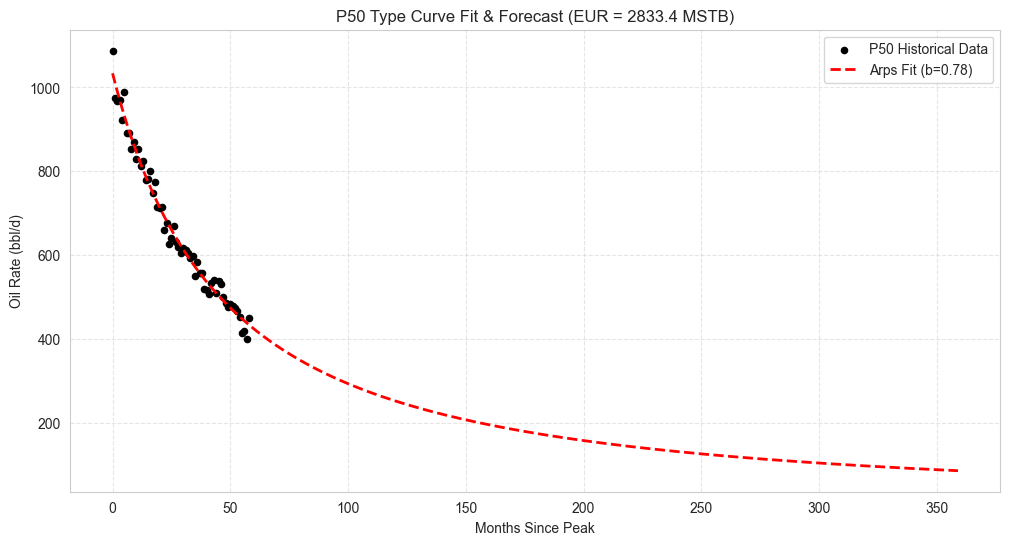

In [8]:
# 1. Generate Forecast for 30 years (360 months)
t_forecast = np.arange(0, 360)
q_forecast = arps_hyperbolic(t_forecast, qi_fit, b_fit, di_fit)

# 2. Calculate EUR (Cumulative Sum)
# Since rate is monthly average bbl/d, monthly volume = rate * 30.4167 (avg days/month)
avg_days_per_month = 30.4167
monthly_volumes = q_forecast * avg_days_per_month
eur_total = np.cumsum(monthly_volumes)[-1]

print(f"Estimated Ultimate Recovery (EUR) over 30 years: {eur_total/1000:.2f} MSTB (Thousand Stock Tank Barrels)")

# 3. Visualization
plt.figure(figsize=(12, 6))

# Plot P50 Historical Data
plt.scatter(t_data, q_data, color='black', label='P50 Historical Data', s=20)

# Plot Arps Fit
plt.plot(t_forecast, q_forecast, color='red', linestyle='--', linewidth=2, label=f'Arps Fit (b={b_fit:.2f})')

plt.title(f"P50 Type Curve Fit & Forecast (EUR = {eur_total/1000:.1f} MSTB)")
plt.xlabel("Months Since Peak")
plt.ylabel("Oil Rate (bbl/d)")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.show()

## Summary
In this exercise, we have:
1.  Loaded production data from 15 offset wells.
2.  Normalized the data by aligning peak production to Time 0.
3.  Generated probabilistic production profiles (P10/P50/P90).
4.  Fitted an Arps Hyperbolic decline model to the P50 profile.
5.  Calculated the Estimated Ultimate Recovery (EUR) for a new well in this area.